In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error

### Regression model - Predicting Type A behaviour

Y variable - typea
X variables - sbp, tobacco, ldl, adiposity, famhist, obesity, alcohol, age

Note that chd is not included as it is the original target variable

In [68]:
df = pd.read_csv("south_african_heart_disease.csv", encoding='ISO-8859-1')

# Drop irrelevant variables
df.drop('row.names', axis=1, inplace=True)

# Transform famhist to binary values
df['famhist'] = np.where(df['famhist'] == 'Present', 1, 0).astype(int)
df.describe()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,0.415584,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,0.493357,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,0.000000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,0.000000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,0.000000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,1.000000,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,1.000000,78.000000,46.580000,147.190000,64.000000,1.000000


### Data Preprocessing

- Log transformation of alcohol and tobacco usage
- Normalization and standardisation of all parameters apart from famhist

In [69]:
# Log-transformation of alcohol and tobacco
df['log_alcohol'] = np.log(df['alcohol'] + 1)
df['log_tobacco'] = np.log(df['tobacco'] + 1)

# Columns to exclude for normalisation
excluded_cols = ['chd']
categorical_cols = ['famhist']

# Numerical columns
numerical_cols = ['ldl', 'adiposity', 'sbp', 'obesity', 'age', 'log_alcohol', 'log_tobacco']

# Initialize StandardScaler
scaler = StandardScaler()

# Apply Z-score normalization only to selected numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [70]:
X = df[numerical_cols + categorical_cols]
Y = df['typea']

### Selection of regularization parameter


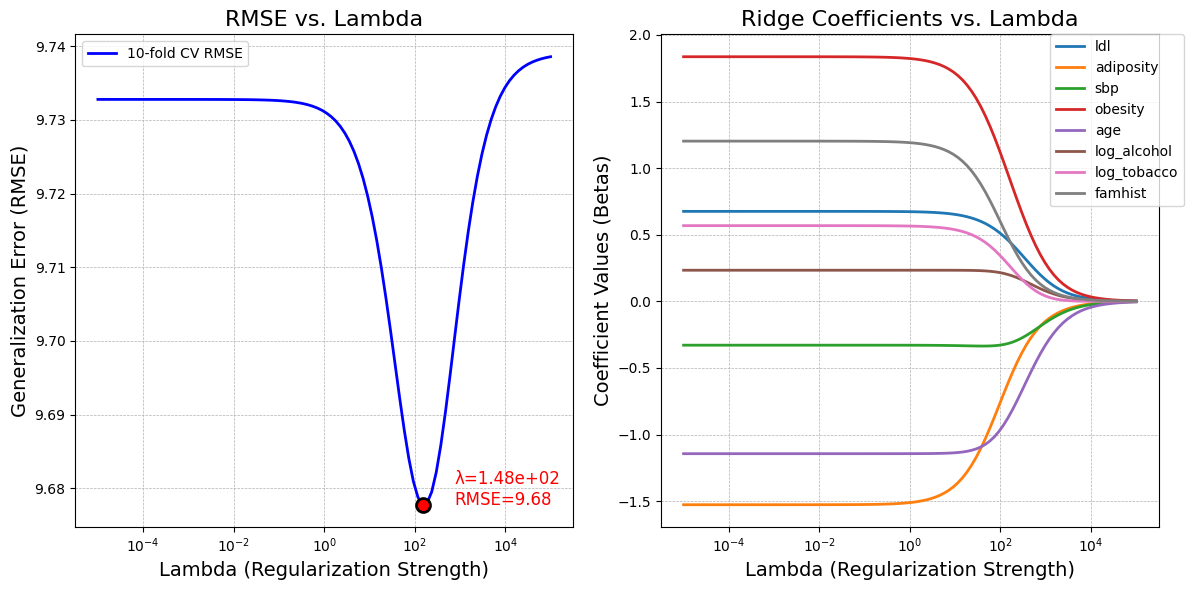

In [71]:
# Range of lambda (regularization strength) values to test
lambda_range = np.logspace(-5, 5, 100)

# Initialize cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store generalization errors (RMSE) for each lambda value
errors = []
coefs = []  # To store betas for each lambda

# Loop over lambda values
for lam in lambda_range:
    fold_errors = []
    
    # Ridge model
    model = Ridge(alpha=lam)
    model.fit(X, Y)  # Fit model on full dataset to get betas
    
    # Store coefficients
    coefs.append(model.coef_)
    
    # Cross-validation for RMSE
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        fold_errors.append(np.sqrt(mean_squared_error(Y_test, Y_pred)))  # RMSE
    
    # Average error across folds
    errors.append(np.mean(fold_errors))

# Convert coefficients list to NumPy array for easy plotting
coefs = np.array(coefs)

# Find the best lambda (minimum RMSE)
min_rmse_index = np.argmin(errors)
min_lambda = lambda_range[min_rmse_index]
min_rmse = errors[min_rmse_index]

# --- RMSE Plot ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.semilogx(lambda_range, errors, label='10-fold CV RMSE', color='blue', linewidth=2)

# Highlight best lambda
plt.scatter(min_lambda, min_rmse, color='red', s=100, zorder=5, edgecolors='black', linewidth=2)
plt.text(x=min_lambda * 5, y=min_rmse, s=f'λ={min_lambda:.2e}\nRMSE={min_rmse:.2f}', color='red', fontsize=12)

plt.xlabel('Lambda (Regularization Strength)', fontsize=14)
plt.ylabel('Generalization Error (RMSE)', fontsize=14)
plt.title('RMSE vs. Lambda', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# --- Beta Coefficients Plot ---
plt.subplot(1, 2, 2)
for i, feature in enumerate(X.columns):
    plt.semilogx(lambda_range, coefs[:, i], label=feature, linewidth=2)  # Each beta vs. lambda

plt.xlabel('Lambda (Regularization Strength)', fontsize=14)
plt.ylabel('Coefficient Values (Betas)', fontsize=14)
plt.title('Ridge Coefficients vs. Lambda', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10, bbox_to_anchor=(1.05, 1), borderaxespad=0.)  # Place legend outside

plt.tight_layout()
plt.show()

In [72]:
# Find the lambda with the lowest RMSE (the best lambda)
min_rmse_index = np.argmin(errors)
best_lambda = lambda_range[min_rmse_index]

# Train the Ridge regression model with the best lambda (from cross-validation)
final_model = Ridge(alpha=best_lambda)
final_model.fit(X, Y)

# Get the coefficients (betas) from the model
coefficients = final_model.coef_

# Create a DataFrame to tabulate the beta values
feature_names = X.columns
beta_table = pd.DataFrame({
    'Feature': feature_names,
    'Beta': coefficients
})

# Sort by absolute value of Beta to show the most influential features first
beta_table['Abs Beta'] = np.abs(beta_table['Beta'])
beta_table = beta_table.sort_values(by='Abs Beta', ascending=False).drop('Abs Beta', axis=1)

# Display the table of coefficients
print(f"Best Lambda: {best_lambda}")
print(beta_table)

Best Lambda: 148.49682622544634
       Feature      Beta
3      obesity  0.950328
4          age -0.871999
1    adiposity -0.610069
7      famhist  0.475680
0          ldl  0.457567
2          sbp -0.316495
6  log_tobacco  0.277540
5  log_alcohol  0.200790


### PCA of features (feature selection)

sdp and adiposity have the wrong coefficient signs (by common sense they should be positively related). Hence, from our first report, I planned to just use PCA to remove those that do not contribute much to the variance

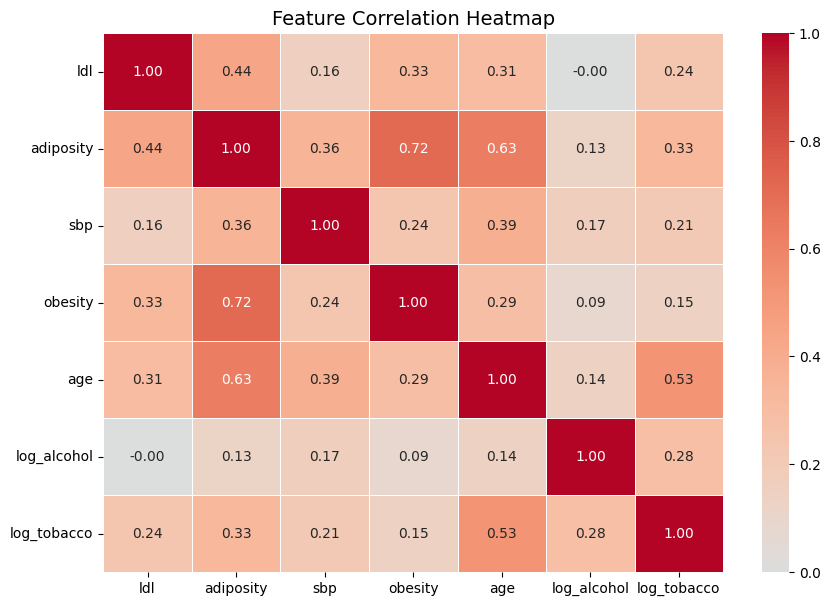

In [73]:
# Compute correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)

# Add title
plt.title("Feature Correlation Heatmap", fontsize=14)

# Show plot
plt.show()

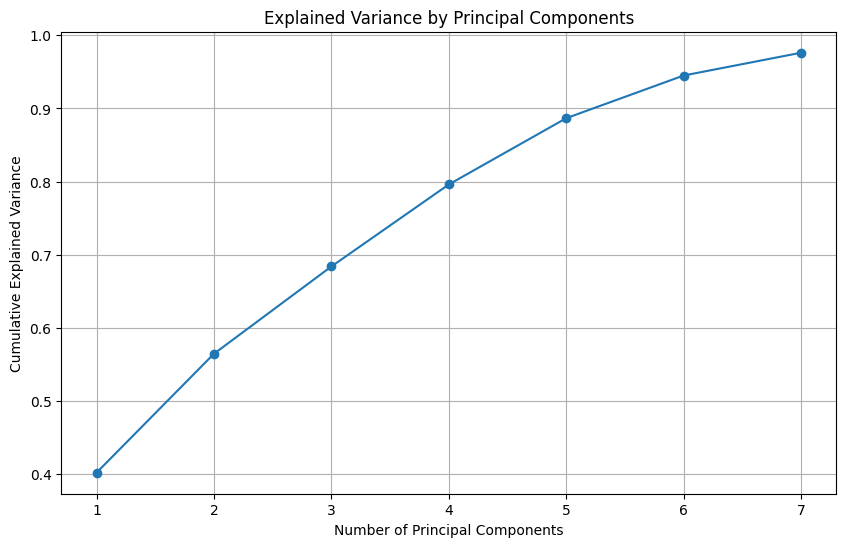

Number of components kept: 6


In [74]:
# Apply PCA
pca = PCA(n_components=len(numerical_cols))  # You can choose fewer components as needed
X_pca = pca.fit_transform(X)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Decide how many components to keep (e.g., keep enough to explain 90% of the variance)
threshold = 0.9
n_components_to_keep = np.argmax(cumulative_variance >= threshold) + 1

# Transform the data using the selected number of components
pca = PCA(n_components=n_components_to_keep)
X_pca_selected = pca.fit_transform(X)

# X_pca_selected is now the data with reduced dimensionality and removed multicollinearity
print(f"Number of components kept: {n_components_to_keep}")

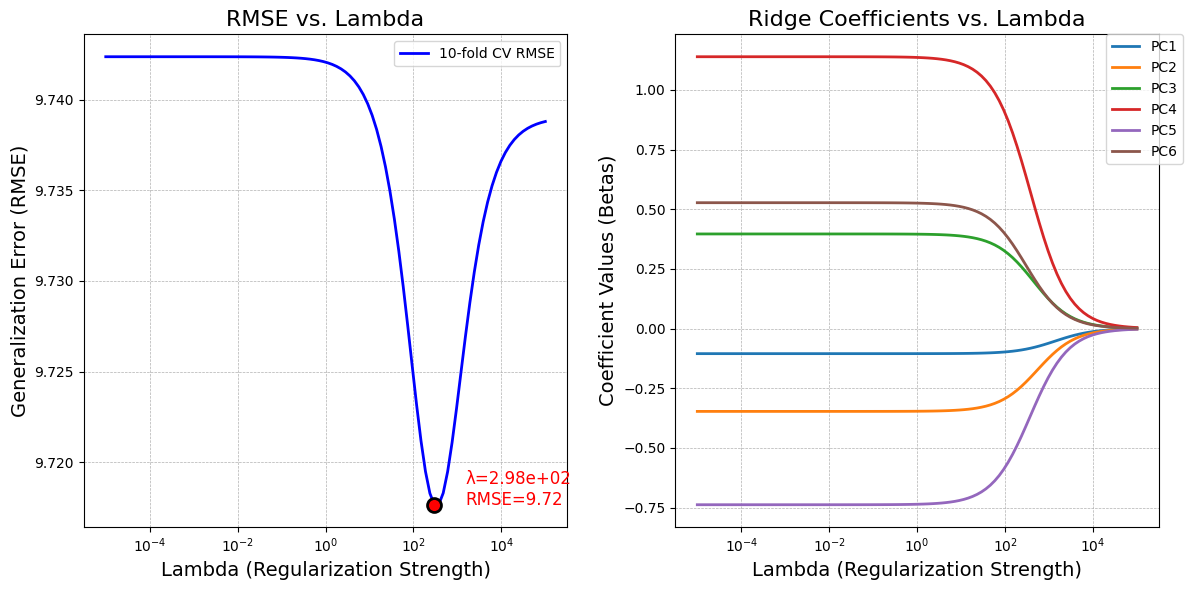

In [75]:
# Standardize the data (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to the scaled data
pca = PCA(n_components=len(numerical_cols))  # We can choose a maximum of 'len(numerical_cols)' components
X_pca = pca.fit_transform(X_scaled)

# Compute the cumulative variance explained by each component
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Select the number of components that explain 90% of the variance
n_components_selected = np.argmax(cumulative_variance >= 0.90) + 1  # Adding 1 because Python indexing starts from 0

# Use only the selected components
X_selected = X_pca[:, :n_components_selected]

# Range of lambda (regularization strength) values to test
lambda_range = np.logspace(-5, 5, 100)

# Initialize cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store generalization errors (RMSE) for each lambda value
errors = []
coefs = []  # To store betas for each lambda

# Loop over lambda values
for lam in lambda_range:
    fold_errors = []
    
    # Ridge model
    model = Ridge(alpha=lam)
    model.fit(X_selected, Y)  # Fit model on full dataset to get betas
    
    # Store coefficients
    coefs.append(model.coef_)
    
    # Cross-validation for RMSE
    for train_index, test_index in kf.split(X_selected):
        X_train, X_test = X_selected[train_index], X_selected[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        fold_errors.append(np.sqrt(mean_squared_error(Y_test, Y_pred)))  # RMSE
    
    # Average error across folds
    errors.append(np.mean(fold_errors))

# Convert coefficients list to NumPy array for easy plotting
coefs = np.array(coefs)

# Find the best lambda (minimum RMSE)
min_rmse_index = np.argmin(errors)
min_lambda = lambda_range[min_rmse_index]
min_rmse = errors[min_rmse_index]

# --- RMSE Plot ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.semilogx(lambda_range, errors, label='10-fold CV RMSE', color='blue', linewidth=2)

# Highlight best lambda
plt.scatter(min_lambda, min_rmse, color='red', s=100, zorder=5, edgecolors='black', linewidth=2)
plt.text(x=min_lambda * 5, y=min_rmse, s=f'λ={min_lambda:.2e}\nRMSE={min_rmse:.2f}', color='red', fontsize=12)

plt.xlabel('Lambda (Regularization Strength)', fontsize=14)
plt.ylabel('Generalization Error (RMSE)', fontsize=14)
plt.title('RMSE vs. Lambda', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# --- Beta Coefficients Plot ---
plt.subplot(1, 2, 2)
for i, feature in enumerate([f"PC{i+1}" for i in range(X_selected.shape[1])]):
    plt.semilogx(lambda_range, coefs[:, i], label=feature, linewidth=2)  # Each beta vs. lambda

plt.xlabel('Lambda (Regularization Strength)', fontsize=14)
plt.ylabel('Coefficient Values (Betas)', fontsize=14)
plt.title('Ridge Coefficients vs. Lambda', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10, bbox_to_anchor=(1.05, 1), borderaxespad=0.)  # Place legend outside

plt.tight_layout()
plt.show()

### ANN and baseline linear regression

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

# --- Baseline Model (Mean of y) ---
baseline_errors = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Baseline: Predict the mean of y on the training data
    baseline_prediction = np.mean(Y_train)
    baseline_error = np.mean((Y_test - baseline_prediction) ** 2)
    baseline_errors.append(baseline_error)

baseline_rmse = np.sqrt(np.mean(baseline_errors))
print(f'Baseline RMSE: {baseline_rmse:.3f}')

# --- Two-level Cross-validation ---
# Define the parameter grid for ANN (MLP) model
hidden_units_range = [1, 5, 10, 20, 50]
lambda_range = np.logspace(-5, 5, 100)

# Store results: Best lambda and h for each fold, along with test errors
table = []

# Outer loop cross-validation (K1 = 10 folds)
for i, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Inner loop: Hyperparameter tuning (using GridSearchCV)
    param_grid = {
        'hidden_layer_sizes': [(h,) for h in hidden_units_range],  # Tuple format for hidden layer size
        'alpha': lambda_range  # Regularization strength
    }
    
    # Define MLP regressor
    mlp_model = MLPRegressor(max_iter=500, random_state=42)
    
    # Grid search for best hyperparameters using cross-validation on training data
    grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, Y_train)
    
    # Get best parameters from the inner loop
    best_h = grid_search.best_params_['hidden_layer_sizes'][0]  # Extract the number of hidden units
    best_lambda = grid_search.best_params_['alpha']
    
    # Get best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Predict on test data and compute RMSE (test error)
    Y_pred = best_model.predict(X_test)
    test_error = np.mean((Y_test - Y_pred) ** 2)  # Squared loss
    
    # Store results for this fold
    table.append([i+1, best_h, best_lambda, test_error])

# Convert results to a DataFrame for better presentation
columns = ['Fold', 'Best h (hidden units)', 'Best λ (regularization)', 'Test Error']
results_df = pd.DataFrame(table, columns=columns)

# Print the table
print(results_df)

# Optionally, display results
# Compute the mean and standard deviation of test errors for each hyperparameter
mean_test_error = results_df['Test Error'].mean()
std_test_error = results_df['Test Error'].std()

print(f'\nAverage Test Error: {mean_test_error:.3f} ± {std_test_error:.3f}')

Baseline RMSE: 9.839


d:\MSE\Y3S2\02450 - Introduction to Artificial Intelligence and Data Mining\02450Toolbox_Python\dtu02450\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\MSE\Y3S2\02450 - Introduction to Artificial Intelligence and Data Mining\02450Toolbox_Python\dtu02450\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\MSE\Y3S2\02450 - Introduction to Artificial Intelligence and Data Mining\02450Toolbox_Python\dtu02450\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\MSE\Y3S2\02450 - Introduction to Artificial Intelligence and 

: 

: 